# Lyrics Generator: Title

To create a lyrics generator based on song titles, we'll need to do the following steps:

  1. Data Preprocessing: Load the dataset you've provided and prepare it for training a Recurrent Neural Network (RNN). This typically includes cleaning the text, tokenizing, and encoding it into sequences that the model can learn from.

2. Model Design: Define an RNN architecture that is suitable for text generation. This usually involves LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit) layers which are good at capturing long-range dependencies in text.

3. Training: Train the RNN on the preprocessed dataset. During this phase, the model will learn to predict the next word in a sequence based on the previous words.

4. Lyrics Generation: Implement a generation loop where we feed a song title (and possibly some starting text) into the model, and the model generates a sequence of text that forms the lyrics.

5. Output Presentation: Design the output to be user-friendly and visually appealing.

## Exploratory Data Analysis (EDA)
We'll start by conducting an initial exploration of the dataset to understand its characteristics. This will include visualizations to comprehend the distribution of song lengths, word frequencies, and the diversity of artists and song titles.

In [1]:
import pandas as pd

# Load the dataset
songs_data = pd.read_csv('./Songs.csv')

# Display the first few rows of the dataframe to understand its structure
songs_data.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new sh*t\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


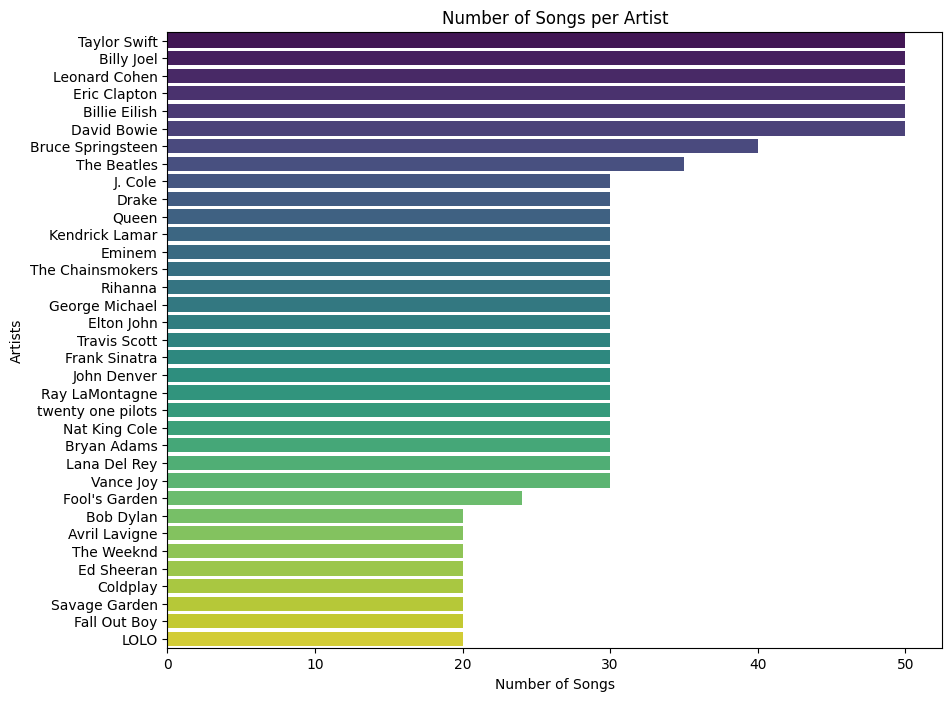

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Basic statistics
artist_counts = songs_data['Artist'].value_counts()
song_lengths = songs_data['Lyrics'].str.split().str.len()

# Visualization of song count per artist
plt.figure(figsize=(10,8))
sns.barplot(x=artist_counts.values, y=artist_counts.index, palette="viridis")
plt.title('Number of Songs per Artist')
plt.xlabel('Number of Songs')
plt.ylabel('Artists')
plt.show()

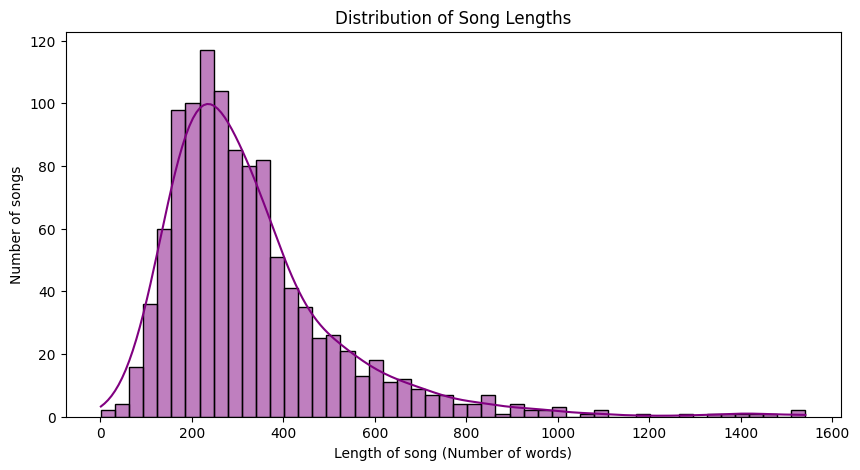

In [3]:
# Visualization of song length distribution
plt.figure(figsize=(10,5))
sns.histplot(song_lengths, bins=50, kde=True, color='purple')
plt.title('Distribution of Song Lengths')
plt.xlabel('Length of song (Number of words)')
plt.ylabel('Number of songs')
plt.show()

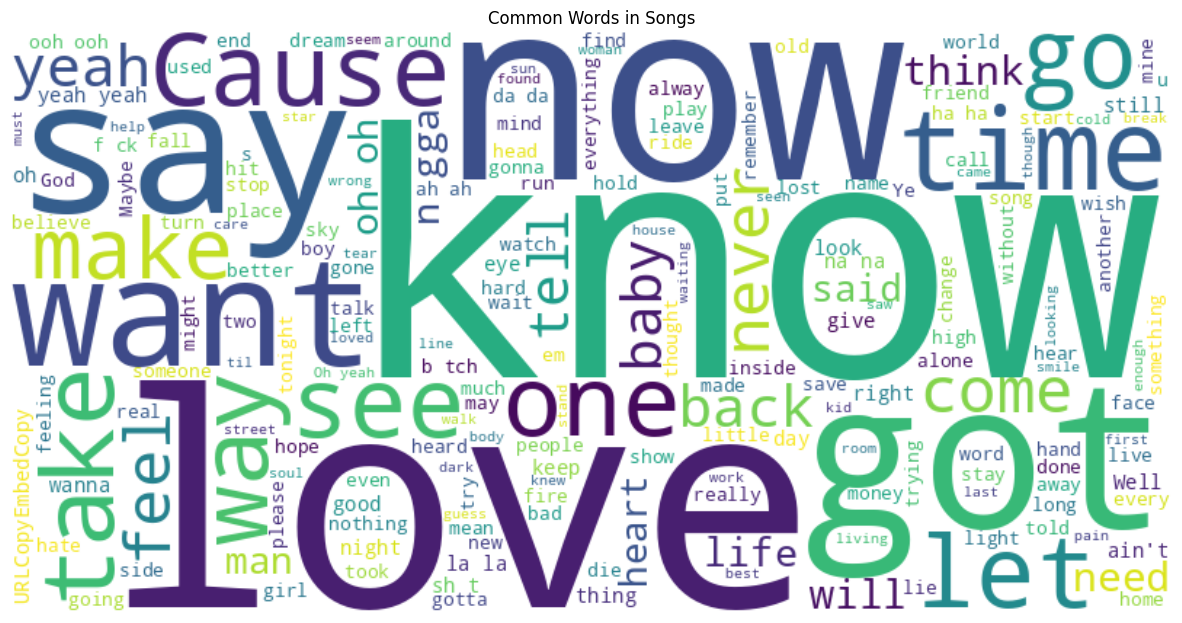

In [4]:
# Word cloud for the most common words in the dataset
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(songs_data['Lyrics']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Songs')
plt.show()

### Exploratory Data Analysis (EDA) Results

The visualizations provide the following insights:

1. **Number of Songs per Artist**: The bar chart shows the distribution of the number of songs for each artist in the dataset.

2. **Distribution of Song Lengths**: The histogram displays the variation in song lengths, measured in the number of words per song. This helps us understand the average length of the lyrics and how verbose or concise the songs are.

3. **Common Words in Songs**: The word cloud gives us a visual representation of the most common words found in the lyrics. The size of each word indicates its frequency.

With these insights, we can proceed to data preprocessing. We'll tokenize the lyrics into words, convert the words into sequences, and numerically encode these sequences.

## Data Preprocessing

To preprocess the text data for our lyrics generation model, we'll perform the following steps:

1. Data Preprocessing: Instead of tokenizing the entire lyrics into sequences, we'll tokenize both the song titles and the corresponding lyrics. The song title will act as the initial context or 'seed' for the lyrics generation.

2. Sequence Creation: We'll create sequences where each sequence starts with the entire song title, followed by a fixed number of words from the lyrics. The model will learn to predict the next word in the lyrics given the title and preceding words.

3. Model Training: During training, the model will use the song titles and preceding words to predict the next word in the lyrics.

4. Lyrics Generation: For generation, the provided title will be used to 'seed' the model. The model will generate one word at a time, adding each new word to the title and previously generated words to continue generating meaningful lyrics.



In [5]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Function to preprocess the data
def preprocess_data_with_titles(df, title_field, lyrics_field, sequence_length=50):
    # Concatenate song titles with lyrics, separated by a special token
    # The special token is chosen to be unlikely to appear in the actual text
    special_token = " endtitle "
    combined_texts = df[title_field] + special_token + df[lyrics_field]

    # Convert text to lowercase and remove unwanted characters
    combined_texts = combined_texts.str.lower().str.replace(r"[^a-z'\s]", "", regex=True)

    # Initialize the tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(combined_texts)

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(combined_texts)

    # Prepare the dataset of input to output pairs encoded as integers
    features = []
    targets = []

    for seq in sequences:
        for i in range(1, len(seq)):
            # Take up to sequence_length amount of words as features, include the special token
            extract = seq[:i+1]
            if len(extract) > sequence_length:
                extract = extract[-sequence_length:]  # take the last sequence_length words
            features.append(extract[:-1])
            targets.append(extract[-1])

    # Pad sequences to ensure equal length
    features = pad_sequences(features, maxlen=sequence_length, truncating='pre')

    # One-hot encode the targets
    num_classes = len(tokenizer.word_index) + 1  # Total number of unique words
    targets = np.eye(num_classes)[targets]

    return features, targets, tokenizer.word_index, tokenizer

# Apply the adjusted preprocessing
sequence_length = 50  # This is the length of sequences including the title and some lyrics
features_with_titles, targets_with_titles, word_index_with_titles, tokenizer_with_titles = preprocess_data_with_titles(
    songs_data, 'Title', 'Lyrics', sequence_length)

print(features_with_titles.shape, targets_with_titles.shape, len(word_index_with_titles))


(365758, 50) (365758, 15206) 15205


### The results indicate the following:

1. **features_with_titles has a shape of (365758, 50)**:

  There are 365,758 sequences to be used for training the model.

  Each sequence is 50 tokens long, including words from the song title followed by words from the lyrics.

2. **targets_with_titles has a shape of (365758, 15206)**:

  Corresponding to the 365,758 input sequences, there are 365,758 target tokens.

  Each target is one-hot encoded into a vector of length 15,206, representing the total number of unique tokens in the dataset (the size of the vocabulary).

3. **word_index_with_titles has a length of 15,205**:

  There are 15,205 unique tokens in the dataset, each assigned a unique integer index.

  The additional +1 in the one-hot encoding dimension (15206) is due to the padding token (index 0), which is standard practice in sequence modeling to ensure consistent input lengths.
  
With the data now preprocessed to include context from the titles, we can move on to defining the model. The model will be trained to predict the next word in a sequence based on the provided context, which includes the song title and the preceding lyrics.



## Define the model

This model includes an embedding layer, two LSTM layers with a dropout layer in between to prevent overfitting, and a dense output layer with a softmax activation to predict the probability distribution over the vocabulary.

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model architecture with song titles as context
def create_model_with_titles(sequence_length, num_classes):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=num_classes, output_dim=256, input_length=sequence_length))

    # LSTM layer
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128))

    # Dense layer to predict the next word
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Vocabulary size is the number of unique tokens + 1 for the zero padding
vocab_size = len(word_index_with_titles) + 1

# Create the model with the adjusted sequence length and vocabulary size
lyrics_model_with_titles = create_model_with_titles(sequence_length=50, num_classes=vocab_size)

# Model summary
lyrics_model_with_titles.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 256)           3892736   
                                                                 
 lstm (LSTM)                 (None, 50, 128)           197120    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 15206)             1961574   
                                                                 
Total params: 6183014 (23.59 MB)
Trainable params: 6183014 (23.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training

In [ ]:
lyrics_model_with_titles.fit(features_with_titles, targets_with_titles, epochs=50, batch_size=128)

## Lyrics Generation

In [ ]:
def generate_lyrics(model, tokenizer, seed_title, num_words_to_generate=100):
    # Prepare the seed sequence
    seed_sequence = [tokenizer.word_index[word] for word in seed_title.split() if word in tokenizer.word_index]
    seed_sequence = pad_sequences([seed_sequence], maxlen=50, truncating='pre')

    # Generate lyrics
    lyrics = seed_title
    for _ in range(num_words_to_generate):
        # Predict the next word
        probabilities = model.predict(seed_sequence)[0]
        next_word_index = np.argmax(probabilities)
        next_word = tokenizer.index_word[next_word_index] if next_word_index > 0 else ''

        # Append the next word to the lyrics
        lyrics += ' ' + next_word

        # Update the seed sequence
        seed_sequence = np.append(seed_sequence[0, 1:], next_word_index)
        seed_sequence = pad_sequences([seed_sequence], maxlen=50, truncating='pre')

    return lyrics

In [ ]:
# The seed title for the lyrics generation
seed_title = "love"

# The number of words you want to generate
num_words = 100

# Call the function to generate lyrics
# Make sure the model and tokenizer names match what you've defined in your environment
generated_lyrics = generate_lyrics(lyrics_model_with_titles, tokenizer_with_titles, seed_title, num_words_to_generate=num_words)

# Print the generated lyrics
print(generated_lyrics)
